# 第6章: 機械学習の基礎 #
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50.データの入手・整形 ##
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．  
抽出された事例をランダムに並び替える．  
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する． 
ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ．  
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [4]:
! unzip ./data/NewsAggregatorDataset.zip

Archive:  ./data/NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
! head -n 3  ./data/newsCorpora.csv
#ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550


In [2]:
import random
with open('./data/newsCorpora.csv') as f:
    
    publishers_list = ["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"]
    data = []
    
    #情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する
    for line in f:
        line = line.split('\t')
    
        title = line[1] 
        publisher = line[3]
        category = line[4]
    
        #publishers_listにある事例の時、タイトルとカテゴリをリストに格納する
        if publisher in publishers_list:
            data.append((title,category))
        

#リストの中に格納されたリストの順番をシャッフルし、それぞれ３つのデータに分割し、ファイルに書き込む
shuffled = random.sample(data,len(data))
train_data = shuffled[:int(len(shuffled))*8//10]
valid_data = shuffled[int(len(shuffled))*8//10:int(len(shuffled))*9//10]
test_data = shuffled[int(len(shuffled))*9//10:]

#タブ区切りにした情報を結合し、各データをファイルに書き込む関数
def write_file(fname,data):
    with open(fname,'w') as f:
        for  i in data:
            f.write('\t'.join(i) + '\n')
            
write_file('./work/train.txt',train_data)
write_file('./work/valid.txt',valid_data)
write_file('./work/test.txt',test_data)

In [3]:
! wc -l './work/train.txt' './work/valid.txt' './work/test.txt' 

   10684 ./work/train.txt
    1336 ./work/valid.txt
    1336 ./work/test.txt
   13356 total


In [4]:
from collections import Counter

#カテゴリー数を数える関数
def count_category(data,data_name):
    extracted_categories = []
    for title,category in data:
        extracted_categories.append(category)
    c = Counter(extracted_categories)
    print(data_name,'\t',c)

count_category(train_data,'train')
count_category(valid_data,'valid')
count_category(test_data,'test')

train 	 Counter({'b': 4494, 'e': 4251, 't': 1209, 'm': 730})
valid 	 Counter({'b': 570, 'e': 507, 't': 170, 'm': 89})
test 	 Counter({'b': 563, 'e': 536, 't': 146, 'm': 91})


In [5]:
#ちなみにライブラリを使うとこんな感じ
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/newsCorpora.csv',names=("ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"),sep="\t")

#データの抽出
df = df.loc[df["PUBLISHER"].isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"]),["TITLE","CATEGORY"]]
#print(df.head())

#データをランダムに並び替え、学習データと検証データ・評価データに分割（デフォルトは25%がテスト用、75%が訓練用になる）
#分割の再現性を持たせるため乱数のシード値を設定、stratifyで正解ラベルを指定（ここではCATEGORY)
train , valid_and_test = (train_test_split(df , test_size = 0.2 , shuffle = True , random_state = 0 , stratify = df["CATEGORY"]))
valid , test = (train_test_split(valid_and_test , test_size = 0.5 , shuffle = True , random_state = 0 , stratify = valid_and_test["CATEGORY"]))

#カテゴリ数の確認(b = business, t = science and technology, e = entertainment, m = health)
print("[学習データのカテゴリ数]")
print(train["CATEGORY"].value_counts())

print("[評価データのカテゴリ数]")
print(test["CATEGORY"].value_counts())

#ライブラリ偉大だけど熟知しないと難しい気もする

[学習データのカテゴリ数]
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
[評価データのカテゴリ数]
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出 ##
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．   
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．  
記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [6]:
#特徴量:特徴が数値化されたもののこと(ex:身長、体重、性別)
#特徴量を単語の出現頻度とする（TF-IDF）
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vec = TfidfVectorizer(stop_words = 'english')


#タイトルを抽出する関数
def make_corpus(data):
    corpus = []
    for t,c in data:
        corpus.append(t)
        corpus
    return corpus

#カテゴリを抽出し、数字（b:0,e:1,t:2,m:3)に変換する関数
def get_category_num(data):
    category_list = []
    categories = ['b','e','t','m']
    for t,c in data:
        category_list.append(c)
        
    #リストのインデックス番号を当てはめる
    data_y = [categories.index(i) for i in category_list]
    return data_y

#TF-IDFを習得する関数
def get_tfidf(corpus):
    
    if corpus == train_corpus:
        data_x = tfidf_vec.fit_transform(corpus)
        #df_tfidf = pd.DataFrame(data=tfidf.toarray(),columns = tfidf_vec.get_feature_names(),index=corpus)  
        
    else:
        data_x = tfidf_vec.transform(corpus)
        #df_tfidf = pd.DataFrame(data=tfidf.toarray(),columns = tfidf_vec.get_feature_names(),index=corpus)  
    
    return data_x

#ファイルに書き込む関数
def write_file(fname,data_x,data_y):
    np.savetxt(fname,data_x.toarray())
    
train_corpus  = make_corpus(train_data)  
train_x,train_y = get_tfidf(train_corpus),get_category_num(train_data)

valid_corpus = make_corpus(valid_data)
valid_x,valid_y = get_tfidf(valid_corpus),get_category_num(valid_data)

test_corpus = make_corpus(test_data)
test_x,test_y = get_tfidf(test_corpus),get_category_num(test_data)

write_file('./work/train.feature.txt',train_x,train_y)
write_file('./work/valid.feature.txt',valid_x,valid_y)
write_file('./work/test.feature.txt',test_x,test_y)

## 52. 学習 ##
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [7]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=10000 , solver='lbfgs' , multi_class='ovr')
logreg.fit(train_x,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## 53. 予測 ##
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [8]:
#題意は「カテゴリを予測し、その予測確率を計算せよ」で合ってる…？

#カテゴリを予測した値（０〜３）を取得
preds = logreg.predict(train_x)
#予測確率を取得する    
probs = logreg.predict_proba(train_x)
#df_tfidf = pd.DataFrame(data=tfidf.toarray(),columns = tfidf_vec.get_feature_names(),index=corpus)  
pd.DataFrame([[pre,pro] for pre,pro in zip(preds,probs)],columns=['pred','prob'])

,pred,prob
0,0,"[0.9035635583482673, 0.03573422289397706, 0.03..."
1,0,"[0.7327150492788742, 0.19069886992627758, 0.03..."
2,2,"[0.2968198936942394, 0.14082907184219123, 0.48..."
3,1,"[0.14106573576977588, 0.7407993575415086, 0.07..."
4,0,"[0.8506990037465413, 0.046422692880065564, 0.0..."
5,1,"[0.1966229329159396, 0.6816662837995116, 0.077..."
6,2,"[0.30775691252083026, 0.1631919026595186, 0.48..."
7,1,"[0.28603503879683534, 0.36270434112818745, 0.0..."
8,1,"[0.10778528728198421, 0.7736095397658787, 0.08..."
9,1,"[0.12284329916534172, 0.779385377360531, 0.055..."


## 54. 正解率の計測 ##
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [9]:
from sklearn.metrics import accuracy_score
train_pred = logreg.predict(train_x)
train_accuracy = accuracy_score(train_y,train_pred)
print('accuracy of train data:' , train_accuracy)

accuracy of train data: 0.925308873081243


In [10]:
test_pred = logreg.predict(test_x)
test_accuracy = accuracy_score(test_y,test_pred)
print('accuracy of test data:' , test_accuracy)

accuracy of test data: 0.8967065868263473


In [11]:
import sklearn 
print(sklearn.__version__)

0.20.1


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [12]:
#混同行列（confusion matrix）とはクラス分類問題の結果を「実際のクラス」と「予測したクラス」を軸にしてまとめたもの。
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(train_pred,train_y)
cm_test = confusion_matrix(test_pred,test_y)
print('confusion matrix of train data \n',cm_train)
print('confusion matrix of test data \n',cm_test)


confusion matrix of train data 
 [[4403   21  202  101]
 [  60 4227  188  188]
 [  28    3  817    2]
 [   3    0    2  439]]
confusion matrix of test data 
 [[538   6  32  13]
 [ 16 529  28  30]
 [  8   1  85   2]
 [  1   0   1  46]]


## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [13]:
from sklearn.metrics import precision_score,recall_score,f1_score

#まず評価データ上での計測
#適合率を計算（例：bに分類されたデータのうち、実際にbであるデータ数の割合）
precision = precision_score(test_y,test_pred,average=None)

#再現率を計算（例：実際にbであるデータのうち、bに分類されたデータの割合）
recall = recall_score(test_y,test_pred,average=None)

#F1スコアを計算（適合率と再現率の調和平均）
f1 = f1_score(test_y,test_pred,average=None)

pd.DataFrame({'precision score':precision,'recall score':recall,'f1 score':f1},index=['b','e','t','m'])


,precision score,recall score,f1 score
b,0.913413,0.955595,0.934028
e,0.877280,0.986940,0.928885
t,0.885417,0.582192,0.702479
m,0.958333,0.505495,0.661871


In [14]:
#カテゴリごとの性能をマイクロ平均、マクロ平均で統合する

#適合率
precision_micro = precision_score(test_y,test_pred,average='micro')
precision_macro = precision_score(test_y,test_pred,average='macro')

#再現率
recall_micro = recall_score(test_y,test_pred,average='micro')
recall_macro = recall_score(test_y,test_pred,average='macro')

#F1スコア
f1_micro = f1_score(test_y,test_pred,average='micro')
f1_macro = f1_score(test_y,test_pred,average='macro')

pd.DataFrame({'precision score':[precision_micro,precision_macro],'recall score':[recall_micro,recall_macro],'f1 score':[f1_micro,f1_macro]},index=['micro-average','macro-average'])


,precision score,recall score,f1 score
micro-average,0.896707,0.896707,0.896707
macro-average,0.908611,0.757555,0.806816


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [15]:
#特徴量がどんな感じだったか確認
pd.DataFrame(train_x.toarray(),columns=tfidf_vec.get_feature_names())

,00,07,08,0ff,0ut,10,100,1000,100000,100k,...,zombie,zombies,zone,zooey,zuckerberg,zynga,œf,œlousyâ,œpiece,œwaist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#LogisticRegression.coef_で特徴量の重みを取得できる（説明変数の重みwが格納されている）
coefs = logreg.coef_
print(coefs) #確認

#各カテゴリにおける特徴量の重みがリストに格納されているっぽい

[[ 0.12985672  0.09582479  0.04212665 ... -0.06782366 -0.12124254
  -0.02243151]
 [-0.0781447  -0.07244809 -0.03045811 ...  0.12036446  0.1974231
   0.03025847]
 [-0.02248594 -0.02086854 -0.01496474 ... -0.03274715 -0.03304608
  -0.01924822]
 [-0.01807085 -0.01555183 -0.01538229 ... -0.0194945  -0.01927852
  -0.01066531]]


In [17]:
#TF-IDFを特徴量としたので、重みが高い/低い単語を取得したい
words = tfidf_vec.get_feature_names()
coefs = logreg.coef_
categories = ['business','entertainment','science and technology','health']

#(単語,重み)のタプルを作り、特徴量のトップ１０とワースト１０を抽出する

for i,coef in enumerate(coefs):
    word_and_weight = dict(zip(words,coef))
    top_10 = sorted(word_and_weight.items(),key=lambda x:x[1],reverse=True)[:10] 
    worst_10 = sorted(word_and_weight.items(),key=lambda x:x[1],reverse=False)[:10] 
    #top/worst10の（単語,重み）がカテゴリごとにリストに格納された物が返ってくる
   
    print(f'Category:{categories[i]}')
    display(pd.DataFrame({'top 10':top_10,'worst 10':worst_10},index=[i for i in range(1,11)]))

Category:business


,top 10,worst 10
1,"(stocks, 5.056654744308008)","(kardashian, -3.222280451989278)"
2,"(china, 4.625070436872953)","(google, -2.8107500522405826)"
3,"(fed, 4.616097276339143)","(star, -2.808510282350181)"
4,"(bank, 4.364121896921303)","(ebola, -2.677362967000056)"
5,"(update, 4.19053309990886)","(apple, -2.6298867833439474)"
6,"(ecb, 4.186046528839418)","(kim, -2.5350445997321387)"
7,"(euro, 3.9175156315677833)","(chris, -2.375527069642109)"
8,"(profit, 3.878636598767173)","(video, -2.2149648066024525)"
9,"(oil, 3.6525277167542947)","(facebook, -2.2090600422693583)"
10,"(ukraine, 3.6159015343049368)","(miley, -2.201295980051129)"


Category:entertainment


,top 10,worst 10
1,"(kardashian, 4.472605766361757)","(update, -5.767510253601216)"
2,"(chris, 3.5896982444602448)","(china, -3.99119033180976)"
3,"(kim, 3.4700209763456282)","(google, -3.836882256641632)"
4,"(star, 3.3943841315130174)","(stocks, -3.66485699580718)"
5,"(miley, 3.2606480188465197)","(says, -3.3305788518228545)"
6,"(cyrus, 3.1862162210217737)","(billion, -3.313660333100793)"
7,"(paul, 3.007072906954023)","(fed, -3.007397669633543)"
8,"(film, 2.983045063270464)","(facebook, -2.967266207721089)"
9,"(movie, 2.874620929001947)","(ceo, -2.936448032706073)"
10,"(beyonce, 2.746298431178804)","(bank, -2.9337706246841693)"


Category:science and technology


,top 10,worst 10
1,"(google, 7.3240886011331465)","(stocks, -2.6445171759904302)"
2,"(facebook, 6.214986022708775)","(shares, -2.028114612107738)"
3,"(apple, 5.6780080965027295)","(kardashian, -1.9636158233912713)"
4,"(climate, 5.130811993612832)","(fed, -1.857605939127271)"
5,"(microsoft, 4.96751302241382)","(ecb, -1.8448449761794095)"
6,"(tesla, 3.8588694787886677)","(euro, -1.6456026977786509)"
7,"(nasa, 3.636394807917565)","(kim, -1.6421137445201799)"
8,"(gm, 3.6257592526016196)","(dollar, -1.5977637680174774)"
9,"(fcc, 3.441052534137001)","(ukraine, -1.5485321374190992)"
10,"(comcast, 3.272007619217947)","(profit, -1.5472169985402757)"


Category:health


,top 10,worst 10
1,"(ebola, 6.331989243404843)","(kardashian, -1.642807203916231)"
2,"(study, 4.905638655841922)","(stocks, -1.5341395491554484)"
3,"(cancer, 4.772340097070075)","(fed, -1.4353412216647152)"
4,"(fda, 4.764397493481108)","(euro, -1.404314595713473)"
5,"(mers, 4.188267473440572)","(china, -1.4025764078746377)"
6,"(drug, 4.057198763294647)","(ecb, -1.342002100894395)"
7,"(health, 3.439939191137871)","(ceo, -1.3383791077938967)"
8,"(cases, 3.0314100606443413)","(kim, -1.3281291790475724)"
9,"(heart, 3.0238171480900147)","(bank, -1.2728760217033421)"
10,"(virus, 2.839797699758991)","(miley, -1.2575069013618936)"


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．


#### パラメータの正則化について　　
* 重みベクトルの長さがなるべく大きくならないように学習時にペナルティを与える
 * scikit-learnのロジスティック回帰では、デフォルトでL2という正則化が行われている
 *  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
 >penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.
New in version 0.19: l1 penalty with SAGA solver (allowing ‘multinomial’ + L1)
* 正則化の強さを変えると適合をコントロールできる
 * 数値が小さい方が正則化が強い

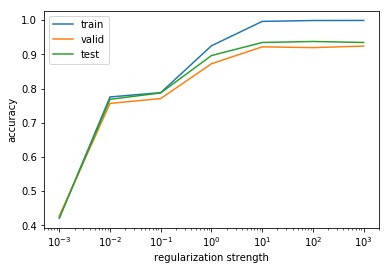

In [18]:
import matplotlib.pyplot as plt 
#scikit-learnでは、cというパラメータで正則化の強さを調整できる(default=1.0)

value_of_C = [10**i for i in range(-3,4)]
train_result = []
valid_result = []
test_result = []


#各条件で学習
for c in value_of_C:
    lr = LogisticRegression(C=c , max_iter=100000 , solver='lbfgs' , multi_class='ovr')
    lr.fit(train_x,train_y)
    
    #正解率を求める
    train_pred = lr.predict(train_x)
    train_accuracy = accuracy_score(train_y,train_pred)
   
    valid_pred = lr.predict(valid_x)
    valid_accuracy = accuracy_score(valid_y,valid_pred)
    
    test_pred = lr.predict(test_x)
    test_accuracy = accuracy_score(test_y,test_pred)
   
    train_result.append(train_accuracy)
    valid_result.append(valid_accuracy)
    test_result.append(test_accuracy)

#グラフにまとめる
plt.plot(value_of_C,train_result,label='train')
plt.plot(value_of_C,valid_result,label='valid')
plt.plot(value_of_C,test_result,label='test')
plt.xscale('log')
plt.xlabel('regularization strength')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

ハイパーパラメータ（英語: Hyperparameter）とは、推論や予測の枠組みの中で決定されないパラメータのことを指す。損失関数の正則化項の影響度を表す係数などが該当する。https://www.wikiwand.com/ja/%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF

In [38]:
from sklearn.model_selection import GridSearchCV
#sklearnのグリッドリサーチという機能を使い、機械学習モデルのハイパーパラメータを自動的に最適化
#予めハイパーパラメータの範囲を指定して一番いいものをパラメータにする
#今回は学習アルゴリズム(solver)

#グリッドサーチのパラメータを設定
params = {lr: {'C': value_of_C ,'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}}

best_accuracy = 0
best_model = 0
          
#グリッドサーチ
for model , param in params.items():
    
    gs = GridSearchCV(model,param,cv=5)
    gs.fit(train_x,train_y)
    
    #検証データでの正解率
    lr = LogisticRegression(C=c , max_iter=1000 ,solver ='lbfgs' ,multi_class='ovr')
    lr.fit(train_x,train_y)
    valid_pred = lr.predict(valid_x)
    accuracy = accuracy_score(valid_y,valid_pred)
          
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        #最適なパラメータを表示
        best_param = gs.best_params_
        best_model = lr       

print('best accuracy of valid data:{}'.format(best_accuracy))
print('best model:{}'.format(best_model))
          

best accuracy of valid data:0.9244011976047904
best model:LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


In [41]:
#評価データの正解率
test_pred = best_model.predict(test_x)
test_accuracy = accuracy_score(test_y,test_pred)
print('accuracy score of test data:{}'.format(test_accuracy))

#訓練データの正解率も上がってる〜
train_pred = best_model.predict(train_x)
train_accuracy = accuracy_score(train_y,train_pred)
print('accuracy score of train data:{}'.format(train_accuracy))

accuracy score of test data:0.9348802395209581
accuracy score of train data:0.9993448146761512
